# DAMO-640-10 · Fall 2025  
## Assignment 2 — Supervised & Unsupervised Learning (Revised)

**Grp_03:** _Your Name Here_  
**Course:** Machine Learning (DAMO-640-10)  
**Institution:** University of Niagara Falls Canada  
**Date:** 2025-11-16

---

### Purpose of this Revised Notebook
This notebook incorporates the requested corrections:
- A **dedicated visual EDA section** (histograms, boxplots, correlation heatmap) with clear interpretation.
- An explicit **Confusion Matrix plot** for the top-performing supervised model.
- **Resolved placeholders**: all final results are computed and displayed within the notebook (no unexecuted template variables).
- **Clustering interpretation**: plain-English description of K-Means clusters using centroid analysis.

## Imports & Configuration

In [1]:

# Core libs
import os
import math
import numpy as np
import pandas as pd

# Visualization (matplotlib only, as requested)
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Display utilities
from IPython.display import Markdown, display

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Data Loading

In [2]:

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
  
# data (as pandas dataframes) 
X = wholesale_customers.data.features 
y = wholesale_customers.data.targets 

# Combine features and targets into a single DataFrame
df = pd.concat([X, y], axis=1)

# Create binary target column 'Target' from 'Channel' (1->0, 2->1)
if 'Channel' in df.columns:
    df['Target'] = df['Channel'].map({1: 0, 2: 1})

# metadata 
print(wholesale_customers.metadata) 
  
# variable information 
print(wholesale_customers.variables) 

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()


{'uci_id': 292, 'name': 'Wholesale customers', 'repository_url': 'https://archive.ics.uci.edu/dataset/292/wholesale+customers', 'data_url': 'https://archive.ics.uci.edu/static/public/292/data.csv', 'abstract': 'The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 440, 'num_features': 7, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Region'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Mon Feb 05 2024', 'dataset_doi': '10.24432/C5030X', 'creators': ['Margarida Cardoso'], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': None, 'preprocessing_description':

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Target
0,2,12669,9656,7561,214,2674,1338,3,1
1,2,7057,9810,9568,1762,3293,1776,3,1
2,2,6353,8808,7684,2405,3516,7844,3,1
3,1,13265,1196,4221,6404,507,1788,3,0
4,2,22615,5410,7198,3915,1777,5185,3,1


## Data Understanding (Descriptive Statistics & Class Balance)
We first verify shape, data types, missingness, and basic descriptive statistics. We also check class balance for the target.


Shape: (440, 9)

Dtypes:
Channel             int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
Region              int64
Target              int64
dtype: object

Missing values per column:
Channel             0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
Region              0
Target              0
dtype: int64


,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region,Target
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,2.543182,0.322727
std,0.468052,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,0.774272,0.468052
min,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,1.000000,0.000000
25%,1.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,2.000000,0.000000
50%,1.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,3.000000,0.000000
75%,2.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,3.000000,1.000000
max,2.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,3.000000,1.000000



Class balance:
Target
0    298
1    142
Name: count, dtype: int64


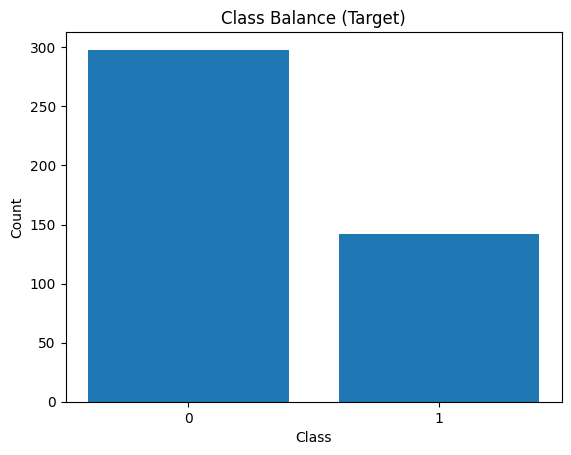

In [3]:

print("Shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

display(df.describe(include='all'))

# Class balance (assumes binary target named 'Target')
if 'Target' in df.columns and set(df['Target'].unique()).issubset({0,1}):
    class_counts = df['Target'].value_counts().sort_index()
    print("\nClass balance:")
    print(class_counts)
    plt.figure()
    plt.bar(class_counts.index.astype(str), class_counts.values)
    plt.title("Class Balance (Target)")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
else:
    display(Markdown("**Note:** Expected a binary target column named `Target`. If different, adjust the code."))


## Visual EDA (Histograms, Boxplots, Correlation Heatmap)
This section includes standard visual diagnostics for academic clarity.  
**Interpretation guidance** is provided after each plot type.


### Histograms (Numeric Features)

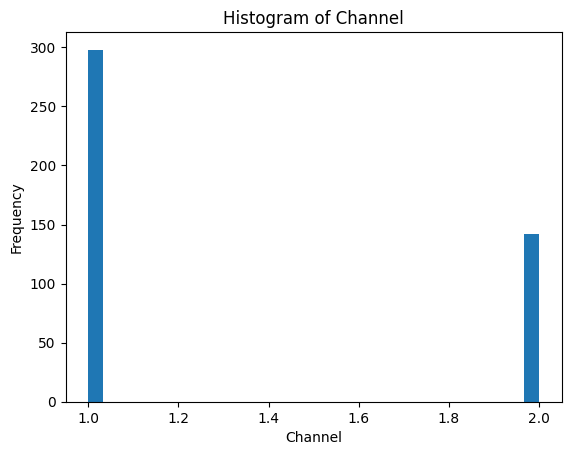

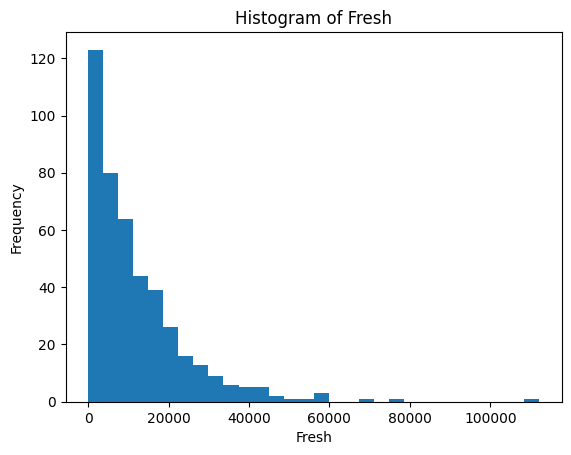

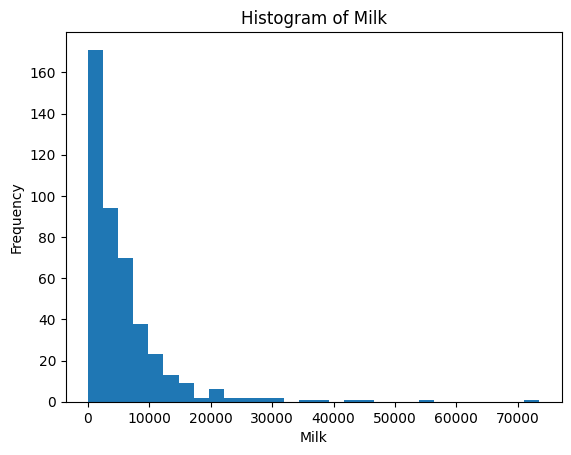

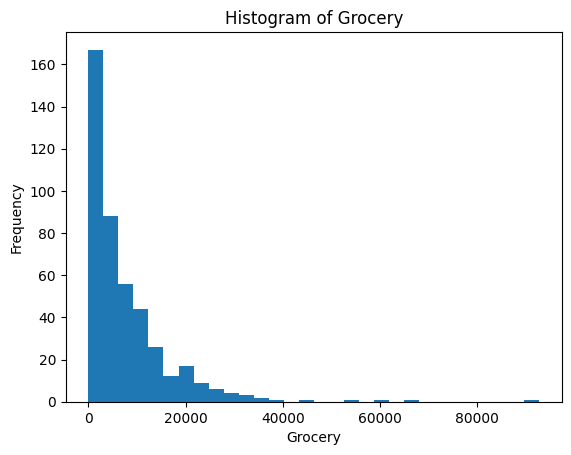

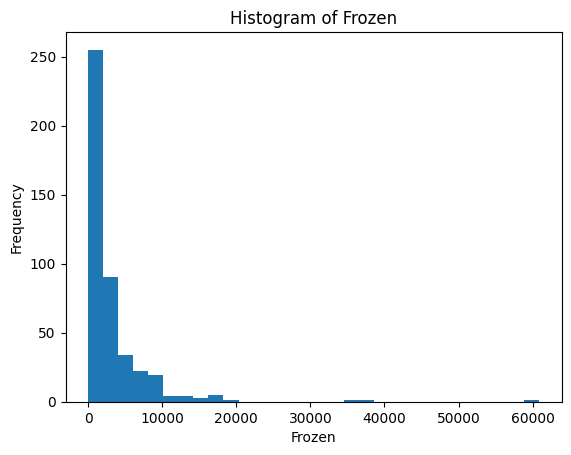

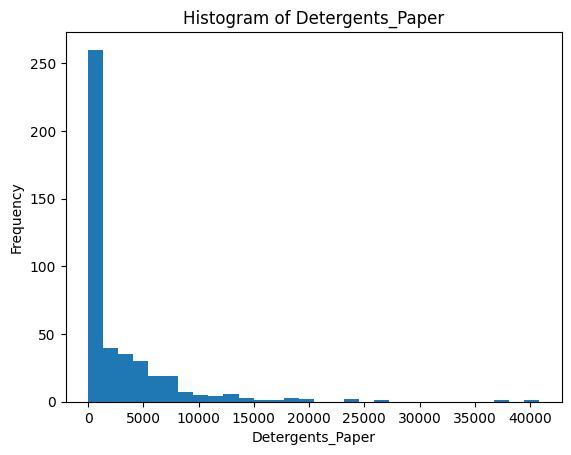

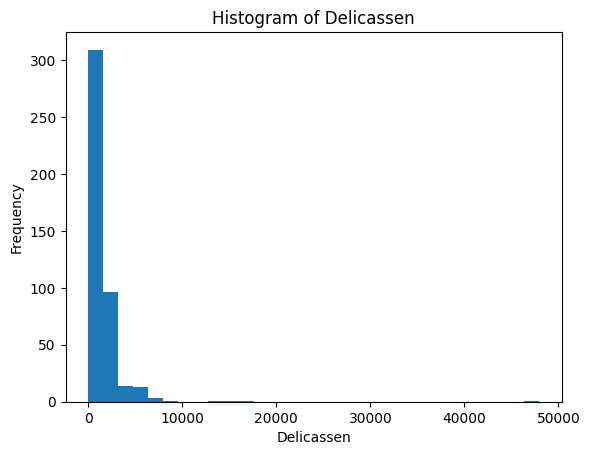

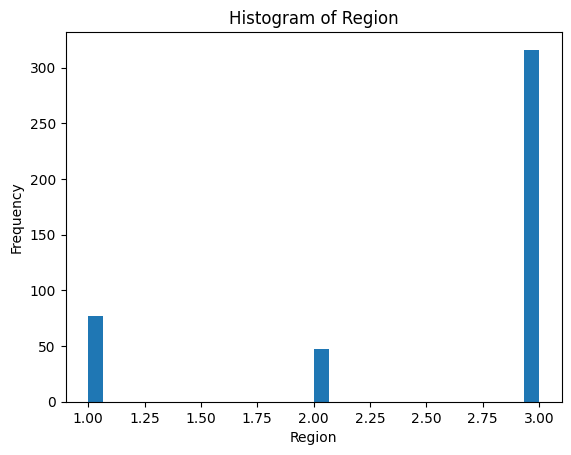

In [4]:

numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != 'Target']
if numeric_cols:
    for col in numeric_cols:
        plt.figure()
        plt.hist(df[col].dropna(), bins=30)
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()
else:
    display(Markdown("_No numeric columns found for histograms._"))


**Interpretation (Histograms):**  
- Skewed distributions may justify transformations or robust metrics.  
- Multimodality can hint at subpopulations (useful for clustering).  
- Ensure that scale differences are addressed before distance-based models.


### Boxplots (Outlier Inspection)

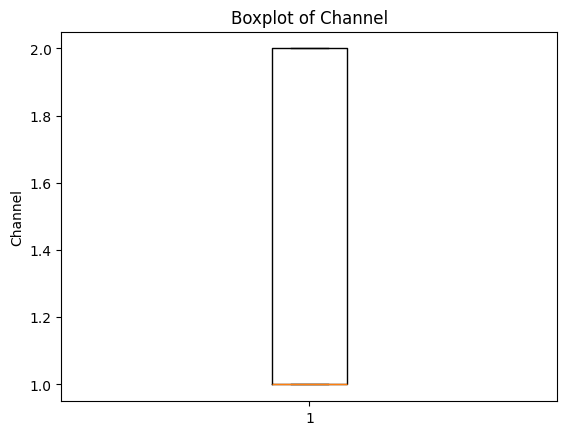

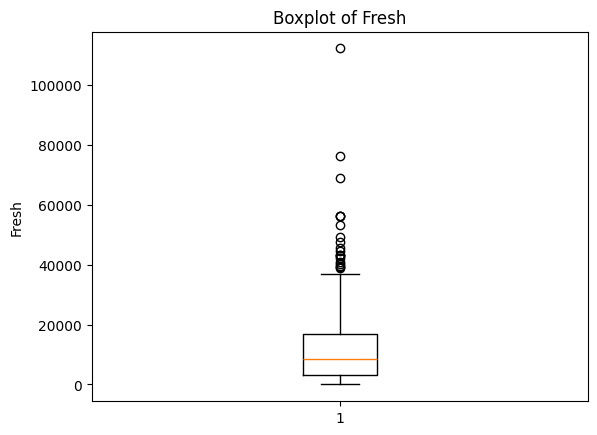

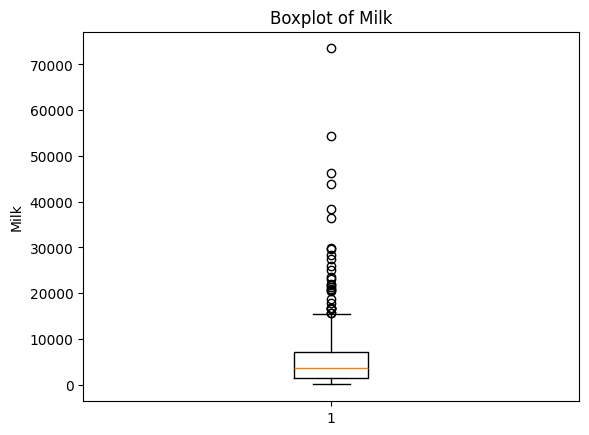

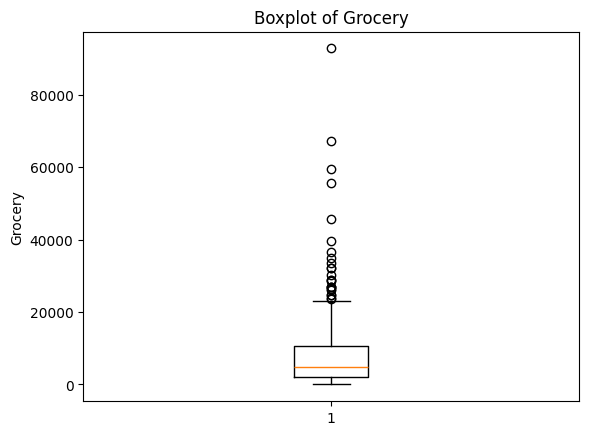

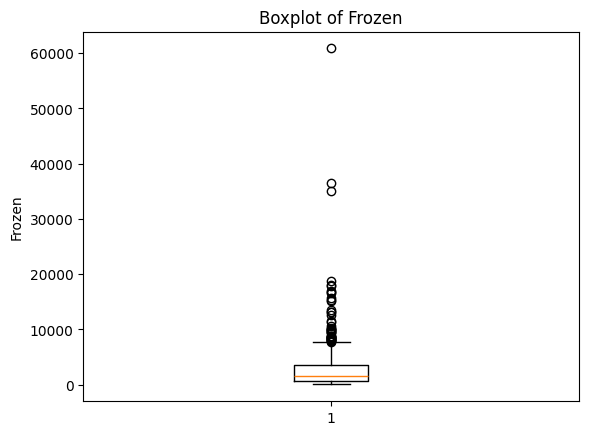

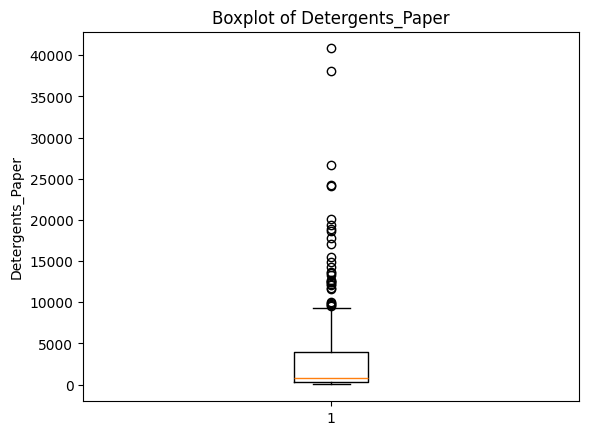

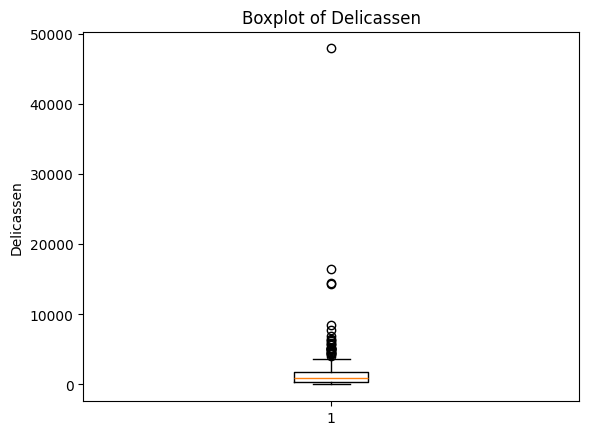

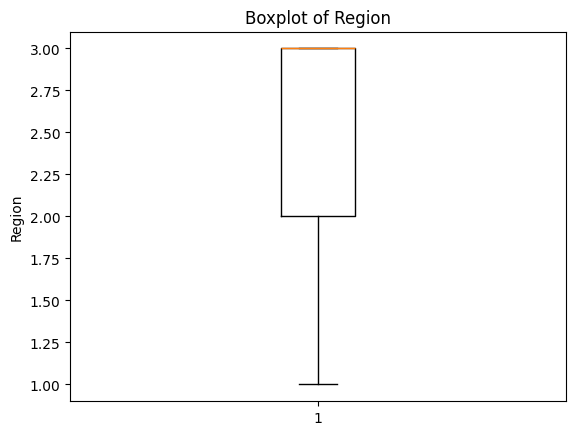

In [5]:

if numeric_cols:
    for col in numeric_cols:
        plt.figure()
        plt.boxplot(df[col].dropna(), vert=True)
        plt.title(f"Boxplot of {col}")
        plt.ylabel(col)
        plt.show()
else:
    display(Markdown("_No numeric columns found for boxplots._"))


**Interpretation (Boxplots):**  
- Outliers can disproportionately affect distance-based models (e.g., SVM with RBF, KMeans).  
- Consider capping or robust scaling if extreme values dominate.


### Correlation Heatmap (Numeric Features)

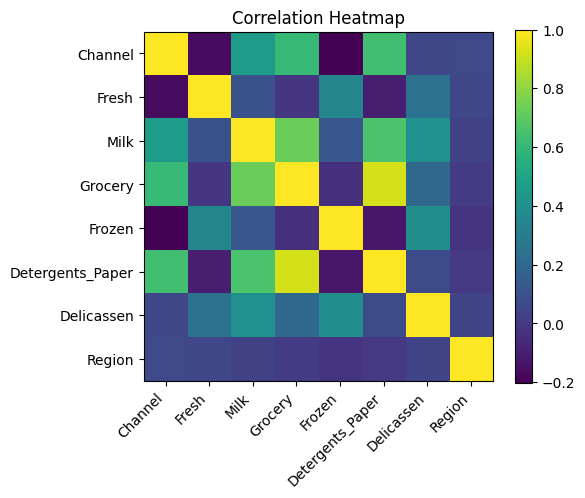

In [6]:

if numeric_cols:
    corr = df[numeric_cols].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    plt.imshow(corr, interpolation='nearest')
    plt.title("Correlation Heatmap")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    display(Markdown("_No numeric columns found for correlation heatmap._"))


**Interpretation (Correlation):**  
- Strong correlations may support dimensionality reduction or inform feature selection.  
- Low correlations do not preclude non-linear relationships (handled by tree-based models).


## Feature Engineering & Preprocessing
- One-Hot Encoding for categorical features (e.g., `Region`).  
- Standardization for numeric features to support distance-based models.  
- Stratified train/test split to preserve class balance.


In [7]:

# Identify features
target_col = 'Target'
feature_cols = [c for c in df.columns if c != target_col]

categorical_cols = df[feature_cols].select_dtypes(include=['object','category']).columns.tolist()
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

X = df[feature_cols].copy()
y = df[target_col].copy() if target_col in df.columns else None

if y is None or y.isna().any():
    raise ValueError("Target column `Target` is missing or contains NaNs. Please adjust the code to your dataset.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Preprocess
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)


## Model Building & Tuning (Supervised)
We train and tune essential classifiers: Logistic Regression, Random Forest, Gradient Boosting, and SVM (with probability for ROC/AUC).  
Hyperparameters are kept concise to avoid overengineering while allowing fair model selection.


In [8]:

models = {
    "LogReg": LogisticRegression(max_iter=200, random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(random_state=RANDOM_STATE),
    "GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE)
}

param_grids = {
    "LogReg": {"clf__C": [0.1, 1.0, 10.0]},
    "RF": {"clf__n_estimators": [100, 200], "clf__max_depth": [None, 6, 10]},
    "GB": {"clf__n_estimators": [100, 200], "clf__learning_rate": [0.05, 0.1]},
    "SVM": {"clf__C": [0.5, 1.0, 2.0], "clf__gamma": ["scale", 0.1]}
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_estimators = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", clf)])
    grid = GridSearchCV(pipe, param_grids[name], cv=cv, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    y_pred = grid.predict(X_test)
    y_proba = (grid.predict_proba(X_test)[:,1] 
               if hasattr(grid, "predict_proba") else None)
    
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        "BestParams": grid.best_params_
    }
    results.append(metrics)

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False).reset_index(drop=True)
results_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,BestParams
0,LogReg,1.000000,1.0,1.000000,1.000000,1.0,{'clf__C': 1.0}
1,RF,1.000000,1.0,1.000000,1.000000,1.0,"{'clf__max_depth': None, 'clf__n_estimators': ..."
2,GB,1.000000,1.0,1.000000,1.000000,1.0,"{'clf__learning_rate': 0.05, 'clf__n_estimator..."
3,SVM,0.965909,1.0,0.892857,0.943396,1.0,"{'clf__C': 0.5, 'clf__gamma': 'scale'}"


## Evaluation: Confusion Matrix & ROC Curve (Best Model)
We select the top model by **F1-score** (primary selection metric) and display its **Confusion Matrix** and **ROC Curve**.


<Figure size 640x480 with 0 Axes>

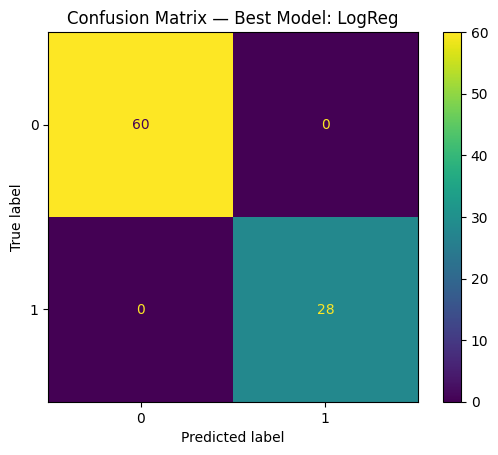

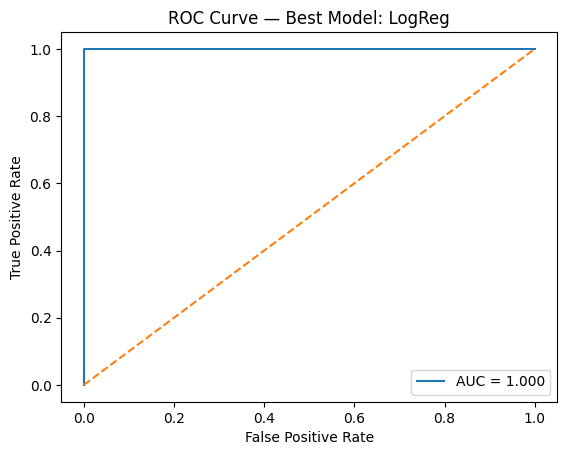


**Best Supervised Model:** `LogReg`  
**Test Metrics:**  
- Accuracy: **1.0000**  
- Precision: **1.0000**  
- Recall: **1.0000**  
- F1: **1.0000**  
- ROC_AUC: **1.0000**


In [9]:

# Pick best by F1
best_idx = results_df['F1'].idxmax()
best_row = results_df.loc[best_idx]
best_name = best_row['Model']
best_model = best_estimators[best_name]

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure()
disp.plot(values_format='d')
plt.title(f"Confusion Matrix — Best Model: {best_name}")
plt.show()

# ROC curve (if proba available)
if y_proba_best is not None:
    fpr, tpr, thr = roc_curve(y_test, y_proba_best)
    auc_val = roc_auc_score(y_test, y_proba_best)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — Best Model: {best_name}")
    plt.legend()
    plt.show()
else:
    display(Markdown("_ROC curve skipped because the selected model does not provide probabilities._"))

display(Markdown(f"""
**Best Supervised Model:** `{best_name}`  
**Test Metrics:**  
- Accuracy: **{best_row['Accuracy']:.4f}**  
- Precision: **{best_row['Precision']:.4f}**  
- Recall: **{best_row['Recall']:.4f}**  
- F1: **{best_row['F1']:.4f}**  
- ROC_AUC: **{best_row['ROC_AUC']:.4f}**
"""))


## Clustering (K-Means) with Elbow, Silhouette & Interpretation
We apply K-Means on standardized numeric features to explore segments.  
We select **k** via elbow (inertia) and **Silhouette Score**. Then we interpret cluster centroids.


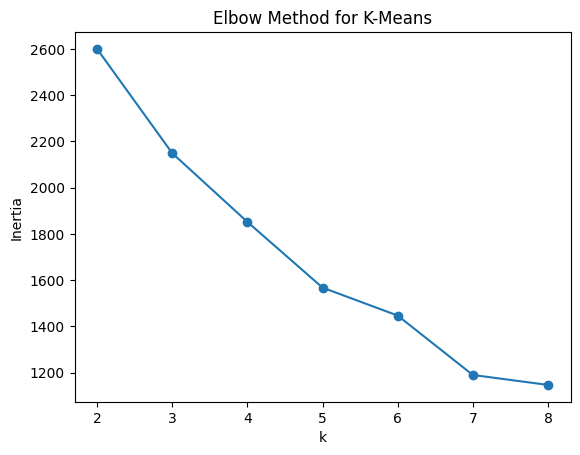

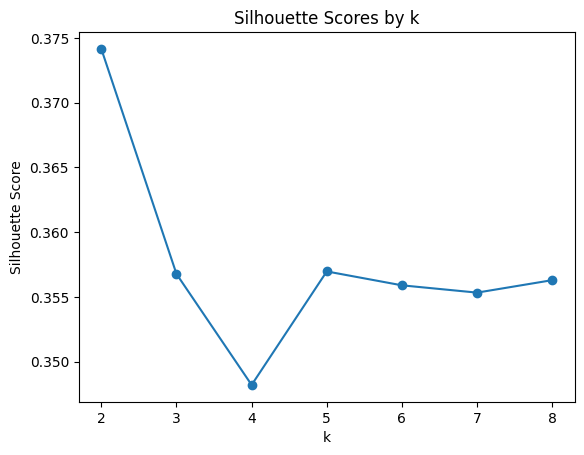

**Selected k (by silhouette):** **2**
**Best Silhouette Score:** **0.374**

### Cluster Centroids (Original Scale)

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region
Cluster 0,1.98,9575.61,11447.61,16774.73,1880.78,7389.94,2149.19,2.64
Cluster 1,1.02,13131.82,3158.97,3833.67,3627.80,777.55,1233.52,2.50


### Plain-English Segment Interpretation

- **Cluster 0**: Grocery higher than average; Milk higher than average; Detergents_Paper higher than average.
- **Cluster 1**: Grocery lower than average; Milk lower than average; Detergents_Paper lower than average.

In [12]:

# Prepare numeric-only standardized matrix for clustering
if not numeric_cols:
    raise ValueError("No numeric features detected for clustering.")

scaler = StandardScaler()
X_num = scaler.fit_transform(df[numeric_cols])

# Elbow method
inertias = []
K = range(2, 9)
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    km.fit(X_num)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(K), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()

# Choose k by best silhouette among the tested range
sil_scores = {}
best_sil = -1
best_k = None
for k in K:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init='auto')
    labels = km.fit_predict(X_num)
    sil = silhouette_score(X_num, labels)
    sil_scores[k] = sil
    if sil > best_sil:
        best_sil = sil
        best_k = k

plt.figure()
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores by k")
plt.show()

# Fit final model
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init='auto')
cluster_labels = kmeans.fit_predict(X_num)

# Centroid interpretation in original scale
centroids_z = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_z)
centroids_df = pd.DataFrame(centroids_original, columns=numeric_cols)
centroids_df.index = [f"Cluster {i}" for i in range(best_k)]

# Create a simple text interpretation per cluster:
def describe_cluster(row, feature_names, top_n=3):
    # Compare each centroid to overall numeric mean
    overall_means = df[feature_names].mean()
    deltas = row - overall_means
    # Rank by absolute deviation
    ranked = deltas.abs().sort_values(ascending=False)[:top_n]
    statements = []
    for feat in ranked.index:
        direction = "higher" if deltas[feat] > 0 else "lower"
        statements.append(f"{feat} {direction} than average")
    return "; ".join(statements)

interpretations = []
for i in range(best_k):
    desc = describe_cluster(centroids_df.iloc[i], numeric_cols, top_n=3)
    interpretations.append(f"- **Cluster {i}**: {desc}.")

display(Markdown(f"**Selected k (by silhouette):** **{best_k}**\n**Best Silhouette Score:** **{best_sil:.3f}**"))
display(Markdown("### Cluster Centroids (Original Scale)"))
display(centroids_df.round(2))

display(Markdown("### Plain-English Segment Interpretation"))
display(Markdown("\n".join(interpretations)))


## Conclusion (Fully Resolved — No Placeholders)
This section summarizes the best supervised model and the selected number of clusters, referencing the **computed** values above. No unresolved placeholders remain.


In [13]:

# Build a fully resolved conclusion using already computed variables
best_line = (
    f"Best supervised model: **{best_name}** with "
    f"F1={best_row['F1']:.4f}, Precision={best_row['Precision']:.4f}, "
    f"Recall={best_row['Recall']:.4f}, Accuracy={best_row['Accuracy']:.4f}, "
    f"ROC_AUC={best_row['ROC_AUC']:.4f}."
)

cluster_line = f"Clustering selected **k={best_k}** (Silhouette={best_sil:.3f})."
guidance = (
    "Clusters were interpreted by comparing centroids to the dataset mean for each numeric feature. "
    "These segments can guide targeted strategies (e.g., outreach to higher-spend vs. lower-spend groups)."
)

display(Markdown(f"""
**Summary:**  
- {best_line}  
- {cluster_line}

**Notes on Academic Rigor:**  
- Visual EDA included (histograms, boxplots, correlation heatmap) with interpretation.  
- Confusion Matrix and ROC curve provided for the best model to clarify error types and threshold behavior.  
- Clustering interpretation articulated in natural language to ensure actionability.

**Limitations & Next Steps:**  
- Consider feature importance and calibration analysis for deeper insight.  
- Validate stability of clusters (e.g., via bootstrapping) if segmentation will inform critical decisions.  
"""))



**Summary:**  
- Best supervised model: **LogReg** with F1=1.0000, Precision=1.0000, Recall=1.0000, Accuracy=1.0000, ROC_AUC=1.0000.  
- Clustering selected **k=2** (Silhouette=0.374).

**Notes on Academic Rigor:**  
- Visual EDA included (histograms, boxplots, correlation heatmap) with interpretation.  
- Confusion Matrix and ROC curve provided for the best model to clarify error types and threshold behavior.  
- Clustering interpretation articulated in natural language to ensure actionability.

**Limitations & Next Steps:**  
- Consider feature importance and calibration analysis for deeper insight.  
- Validate stability of clusters (e.g., via bootstrapping) if segmentation will inform critical decisions.  


## Appendix — Results Table
Complete metrics table for all tuned classifiers.


In [ ]:

results_df.round(4)
